# Analyse de l'activité physique au poignet

Projet HAH913E – Danse sur glace / Patinage artistique

Ce notebook charge les données d'accélération du poignet, vérifie la qualité, calcule quelques indicateurs simples et génère les figures utilisées dans le rapport et la présentation.

In [ ]:
git init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Chemin vers ton fichier CSV
DATA_PATH = Path(r"C:\Users\louis\OneDrive\Documents\CWA-DATA.csv")

# Dossier où enregistrer les figures
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

plt.rcParams["figure.figsize"] = (9, 4)



In [17]:
df = pd.read_csv(DATA_PATH, header=None, names=["timestamp", "ax", "ay", "az"])

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["ax"] = df["ax"].astype(float)
df["ay"] = df["ay"].astype(float)
df["az"] = df["az"].astype(float)

df.head()


,timestamp,ax,ay,az
0,2025-10-15 19:20:05.779,1.578125,-0.671875,-1.390625
1,2025-10-15 19:20:05.789,0.031250,0.906250,0.046875
2,2025-10-15 19:20:05.800,0.046875,0.984375,0.000000
3,2025-10-15 19:20:05.809,0.093750,1.031250,-0.046875
4,2025-10-15 19:20:05.819,0.171875,1.062500,-0.046875


In [19]:
t0 = df["timestamp"].iloc[0]
df["time_s"] = (df["timestamp"] - t0).dt.total_seconds()

df["a_tot"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

df.head()


,timestamp,ax,ay,az,time_s,a_tot
0,2025-10-15 19:20:05.779,1.578125,-0.671875,-1.390625,0.000,2.208106
1,2025-10-15 19:20:05.789,0.031250,0.906250,0.046875,0.010,0.907999
2,2025-10-15 19:20:05.800,0.046875,0.984375,0.000000,0.021,0.985490
3,2025-10-15 19:20:05.809,0.093750,1.031250,-0.046875,0.030,1.036563
4,2025-10-15 19:20:05.819,0.171875,1.062500,-0.046875,0.040,1.077332


In [21]:
dts = df["timestamp"].diff().dt.total_seconds().dropna()
dt_mean = dts.mean()
fs = 1.0 / dt_mean

print(f"Pas de temps moyen = {dt_mean:.5f} s")
print(f"Fréquence approx. = {fs:.1f} Hz")


Pas de temps moyen = 0.00966 s
Fréquence approx. = 103.5 Hz


In [23]:
print(df["a_tot"].describe())



count    372120.000000
mean          1.247595
std           1.026176
min           0.015625
25%           0.977780
50%           1.017546
75%           1.141160
max          13.847391
Name: a_tot, dtype: float64


In [25]:
THRESHOLDS_G = [2.0, 3.0, 5.0]

for thr in THRESHOLDS_G:
    n = (df["a_tot"] > thr).sum()
    t = n * dt_mean
    print(f"> {thr} g : {n} points, {t:.1f} s (~ {t/60:.2f} min)")


> 2.0 g : 20156 points, 194.7 s (~ 3.25 min)
> 3.0 g : 12443 points, 120.2 s (~ 2.00 min)
> 5.0 g : 6909 points, 66.8 s (~ 1.11 min)


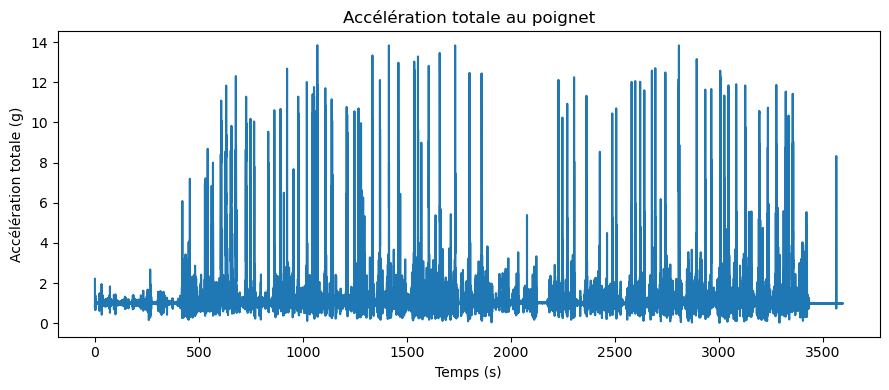

In [27]:
plt.figure()
plt.plot(df["time_s"], df["a_tot"])
plt.xlabel("Temps (s)")
plt.ylabel("Accélération totale (g)")
plt.title("Accélération totale au poignet")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_timeseries.png", dpi=300)
plt.show()


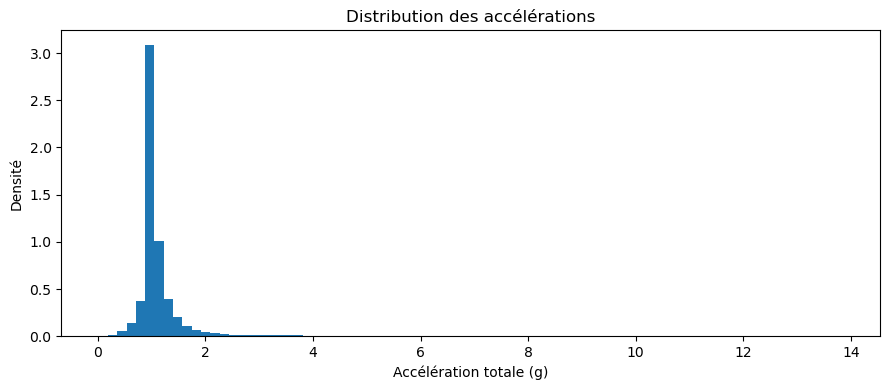

In [29]:
plt.figure()
plt.hist(df["a_tot"], bins=80, density=True)
plt.xlabel("Accélération totale (g)")
plt.ylabel("Densité")
plt.title("Distribution des accélérations")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_hist_accel.png", dpi=300)
plt.show()


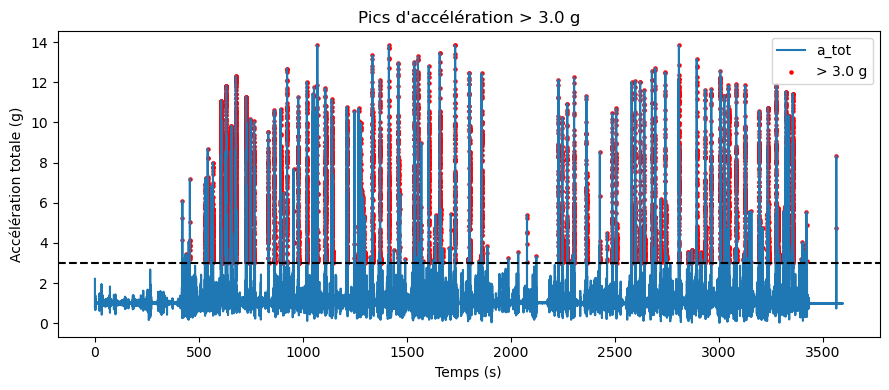

In [31]:
threshold = 3.0
peaks = df[df["a_tot"] > threshold]

plt.figure()
plt.plot(df["time_s"], df["a_tot"], label="a_tot")
plt.scatter(peaks["time_s"], peaks["a_tot"], s=5, color="red", label=f"> {threshold} g")
plt.axhline(threshold, linestyle="--", color="black")
plt.xlabel("Temps (s)")
plt.ylabel("Accélération totale (g)")
plt.title(f"Pics d'accélération > {threshold} g")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / f"fig_peaks_{threshold}g.png", dpi=300)
plt.show()


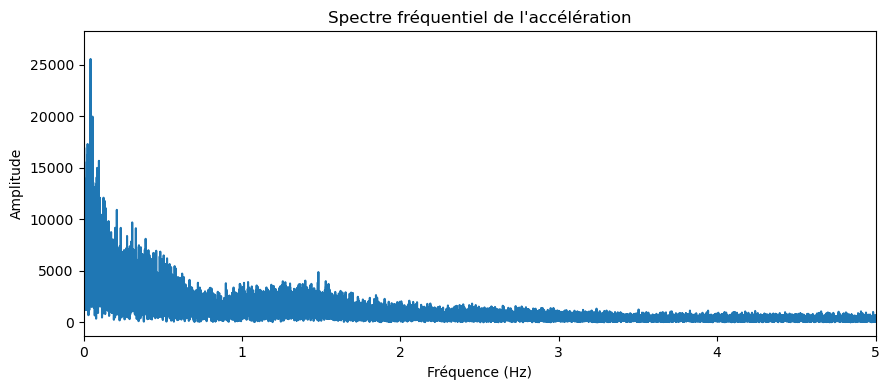

In [33]:
from numpy.fft import rfft, rfftfreq

signal = df["a_tot"] - df["a_tot"].mean()
N = len(signal)

freqs = rfftfreq(N, d=dt_mean)
fft_vals = np.abs(rfft(signal))

plt.figure()
plt.plot(freqs, fft_vals)
plt.xlim(0, 5)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.title("Spectre fréquentiel de l'accélération")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_fft.png", dpi=300)
plt.show()


In [35]:
summary = {
    "duration_min": df["time_s"].iloc[-1] / 60,
    "mean_g": df["a_tot"].mean(),
    "std_g": df["a_tot"].std(),
    "max_g": df["a_tot"].max(),
}

for thr in THRESHOLDS_G:
    n = (df["a_tot"] > thr).sum()
    summary[f"time_above_{thr}g_min"] = n * dt_mean / 60

summary


{'duration_min': 59.92001666666667,
 'mean_g': 1.2475953323511586,
 'std_g': 1.0261764334446206,
 'max_g': 13.847391239530463,
 'time_above_2.0g_min': 3.245595779665465,
 'time_above_3.0g_min': 2.0036191846783775,
 'time_above_5.0g_min': 1.1125134571198996}